# Working with geopandas and folium
**Rick Debbout**
### [Download](https://www.dropbox.com/sh/dzc4b5hsn0dc9vf/AABrX5NoR6W-gakT3Wbdmxo9a?dl=1 "Download") the data

*  **For help setting up the environment with Anaconda, click** [**here.**](https://anaconda.org/debboutr/spatialdatamanagementgroup/notebook)
* **contact me with  problems** <debboutr@gmail.com>

In [34]:
# Point to where you have extracted the data
DL_dir='/home/rick/Downloads/SpatialData' #change this string to the location of the extracted download directory

In [2]:
# import packages
from IPython.display import Image, HTML
% matplotlib inline
import os
import folium
import pandas as pd
import geopandas as gpd
%cd SDMG
from StreamCat_functions import findUpstreamNpy

# Run the next cell for the map, below we will step through the code

In [3]:
def color(pct):
    if pct <= 50:
        col=('green','ok')
    elif 50 < pct <= 75:
        col=('blue','remove')
    elif pct > 75:
        col=('darkred','ban-circle')
    return col  
if not os.path.exists("%s/lks.json" % DL_dir):
    zone = '16'
    lakes = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDWaterbodies.shp' % (DL_dir, zone)).to_crs({'init' :'epsg:5070'})
    cats = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDCatchment.shp' % (DL_dir, zone)).to_crs({'init' :'epsg:5070'}) 
    lookup = pd.read_csv('%s/lookupCOMS%s.csv' % (DL_dir, zone))
    lks = gpd.GeoDataFrame()
    bsn = gpd.GeoDataFrame()
    miss = gpd.GeoDataFrame()
    for idx, row in lookup.iterrows():
        lake = lakes.ix[lakes.COMID == row.wbCOMID]
        catbas = findUpstreamNpy(zone, int(row.catCOMID), DL_dir)
        basin = cats.ix[cats.FEATUREID.isin(catbas)]
        try: 
            diffgeom = lake['geometry'].difference(basin.unary_union.buffer(0))
            pct = diffgeom.area / lake.area * 100
            if pct.values[0] > 20:
                lks = pd.concat([lks, lake])
                bsn = pd.concat([bsn, basin])
                miss = pd.concat([miss, gpd.GeoDataFrame(data={'COMID': row.wbCOMID,'PCT': pct}, geometry=diffgeom)])
        except:
            print row.wbCOMID
            continue
    lks.to_crs({'init' :'epsg:4326'}).to_file("%s/lks.json" % DL_dir, driver="GeoJSON")
    bsn.to_crs({'init' :'epsg:4326'}).to_file("%s/bsn.json" % DL_dir, driver="GeoJSON")
    miss.to_crs({'init' :'epsg:4326'}).to_file("%s/miss.json" % DL_dir, driver="GeoJSON")
miss = gpd.GeoDataFrame.from_file("%s/miss.json" % DL_dir).to_crs({'init' :'epsg:4326'})
extent = miss.unary_union.bounds
lat_Center = (extent[1] + extent[3]) / 2
lon_Center = (extent[0] + extent[2]) / 2
f_map=folium.Map(location=[lat_Center , lon_Center],zoom_start=6,tiles="Stamen Terrain", control_scale=True)
fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name,pct in zip(miss['geometry'].centroid.map(lambda p: p.y),miss['geometry'].centroid.map(lambda p: p.x),miss['COMID'],miss['PCT']):
    html="""
    <p>NHD Waterbody <b>COMID</b>: %s</p><br>
    <p>Percent uncovered: <b>%s %%</b></p>
    """ % (int(name), pct)
    iframe = folium.element.IFrame(html=html, width=300, height=120)
    fg.add_child(folium.Marker(location=[lat,lon],popup=folium.Popup(iframe),
                                   icon=folium.Icon(icon_color='white', color=color(pct)[0], icon=color(pct)[1])))
    f_map.add_child(fg)
f_map.add_child(folium.GeoJson(data=open('%s/lks.json' % DL_dir),
                name='NHD Lake',
                style_function=lambda x: {'fillColor':'blue', 
                                          'fill_opacity': 0.2, 
                                          'color':'none'}))
f_map.add_child(folium.GeoJson(data=open('%s/bsn.json' % DL_dir),
                name='Catchment Basin',
                style_function=lambda x: {'fillColor':'grey', 
                                          'fill_opacity': 0.74,
                                          'color':'white'}))
f_map.add_child(folium.GeoJson(data=open('%s/miss.json' % DL_dir),
                name='Missed Area',
                style_function=lambda x: {'fillColor':'red', 
                                          'fill_opacity': 0.2, 
                                          'color':'none'}))
f_map.add_child(folium.LayerControl())

[Errno 2] No such file or directory: 'SDMG'
/home/rick/SDMG


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -1416315.0000000002 1964474.9999999953 at -1416315.0000000002 1964474.9999999953


1197972.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -1254134.9999999998 2232524.9999999977 at -1254134.9999999998 2232524.9999999977


4472015.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -1327755 2037974.9999999946 at -1327755 2037974.9999999946


10327875.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -1348664.9999999988 2118494.9999999995 at -1348664.9999999988 2118494.9999999995


946020001.0


# Working out the details...

In [ ]:
# geopandas reads data from shapefile OR GeoJSON format into the geopandas.GeoDataFrame object
lakes = gpd.GeoDataFrame.from_file("{}/NHDPlus16/NHDWaterbodies.shp".format(DL_dir))

In [38]:
print "Number of records in lakes: {}".format(len(lakes))  # get the number of records in the GeoDataFrame
print "Number of unique REACHCODEs: {}".format(len(pd.unique(lakes.REACHCODE))) # or unique # of records
lakes.head() # look at the first records of a GeoDataFrame, notice the 'geometry' column

Number of records in lakes: 807
Number of unique REACHCODEs: 797


,AREASQKM,COMID,ELEVATION,FCODE,FDATE,FTYPE,GNIS_ID,GNIS_NAME,REACHCODE,RESOLUTION,SHAPE_AREA,SHAPE_LENG,VPU,geometry
0,0.079,4562850,0.0,39004,1999-06-22,LakePond,None,None,16010202001481,Medium,0.000009,0.019938,16,"POLYGON ((-111.855203003485 41.90411666828982,..."
1,0.102,663806,0.0,39004,1999-06-22,LakePond,1446649,Tony Grove Lake,16010203000737,Medium,0.000011,0.015252,16,POLYGON ((-111.6456740038103 41.89611300163557...
2,0.036,663946,0.0,39004,1999-06-22,LakePond,None,None,16010203000755,Medium,0.000004,0.011745,16,POLYGON ((-111.7176358036986 41.75337126852378...
3,1.044,663954,1343.0,39010,1999-06-22,LakePond,None,None,16010203000753,Medium,0.000113,0.224490,16,"POLYGON ((-111.9423262033498 41.7297770685604,..."
4,0.037,663956,1343.0,39010,1999-06-22,LakePond,None,None,16010203000746,Medium,0.000004,0.010551,16,POLYGON ((-111.9461004700106 41.74514726853653...


In [16]:
?gpd.GeoDataFrame.from_file() # bring up help on any object to find it's parameters

In [17]:
?gpd.read_file() # the above method wraps this one. As you can see, we are using fiona to read in geometries

In [27]:
# The geometry column holds the geometry in a shapely object
type(lakes['geometry'])

geopandas.geoseries.GeoSeries

In [29]:
?gpd.geoseries.GeoSeries  # this tells us that the geometries are stored in shapely objects

In [33]:
#Access the geometry of any shape in the GeoDataFrame
type(lakes.ix[0].geometry) # check the type of the first record's geometry object

shapely.geometry.polygon.Polygon

In [21]:
# Access the Coordinate Reference System and easily reproject
print str(lakes.crs)  + ' -- GCS_North_American_1983'
lakes_albers = lakes.to_crs({'init' :'epsg:5070'})
print str(lakes_albers.crs) + ' -- Albers_Equal_Area'

{'init': u'epsg:4269'} -- GCS_North_American_1983
{'init': 'epsg:5070'} -- Albers_Equal_Area


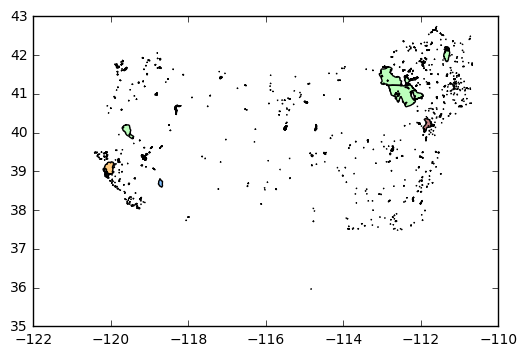

In [35]:
lakes.plot() #plot all of the lakes in the GeoDataFrame

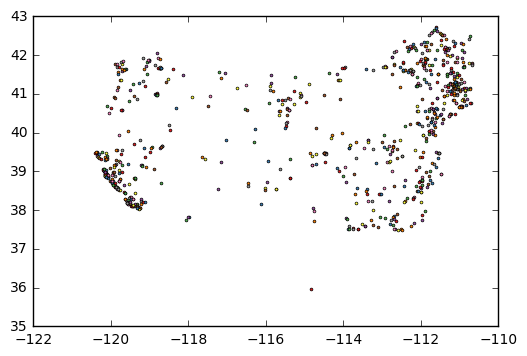

In [36]:
lakes['geometry'].centroid.plot() #plot the centroids of all the lakes

In [39]:
print type(lakes.FTYPE)  # other columns in the GeoDataFrame are pandas Series objects
print lakes.FTYPE[0] # returns index in the series

<class 'pandas.core.series.Series'>
LakePond


In [7]:
lakes.FTYPE.shape # there are many attributes to Series objects, check documentation for more

(807,)

In [8]:
print lakes.dtypes  #find all of the datatypes held in the GeoDataFrame

AREASQKM      float64
COMID           int64
ELEVATION     float64
FCODE           int64
FDATE          object
FTYPE          object
GNIS_ID        object
GNIS_NAME      object
REACHCODE      object
RESOLUTION     object
SHAPE_AREA    float64
SHAPE_LENG    float64
VPU            object
geometry       object
dtype: object


In [52]:
cats.crs

{'init': 'epsg:5070'}

In [42]:
print lakes.index.dtype #DataFrames are assigned an index that can be set
print lakes.index
lakes.set_index('COMID').tail(2) # you can specify the number of records returned in the head/tail method call

int64
RangeIndex(start=0, stop=807, step=1)


,AREASQKM,ELEVATION,FCODE,FDATE,FTYPE,GNIS_ID,GNIS_NAME,REACHCODE,RESOLUTION,SHAPE_AREA,SHAPE_LENG,VPU,geometry
COMID,,,,,,,,,,,,,
11361723,0.234,0.0,39001,1999-08-20,LakePond,851220,Cliff Reservoir,16060009001899,Medium,0.000024,0.023534,16,"POLYGON ((-114.771760998958 37.71186887479701,..."
22819112,0.059,0.0,39004,1999-10-16,LakePond,861140,Robinson Lake,16060007002486,Medium,0.000006,0.010209,16,POLYGON ((-115.2815133981667 40.73089400344423...


In [46]:
#cats = gpd.GeoDataFrame.from_file("{}/NHDPlus16/NHDCatchment.shp".format(DL_dir))
basin = cats.ix[cats.FEATUREID.isin(range(8915961,8915984,2))]
print "Max area catchment: %s SQKM" % basin.AreaSqKM.max()
print "Min area catchment: %s SQKM" % basin.AreaSqKM.min()
print "Mean area of all catchments: %s SQKM" % basin.AreaSqKM.mean()
print "STD of all catchments: %s" % basin.AreaSqKM.std()

Max area catchment: 11.8476 SQKM
Min area catchment: 0.3078 SQKM
Mean area of all catchments: 3.5319 SQKM
STD of all catchments: 3.79137471038


In [45]:
basin.sort_values('AreaSqKM',ascending=False) # sort the DF by an attribute

,AreaSqKM,FEATUREID,GRIDCODE,SOURCEFC,geometry
1989,11.8476,8915983,2025935,NHDFlowline,POLYGON ((-1998944.999999998 1935405.000000001...
1997,10.6200,8915975,2025951,NHDFlowline,"POLYGON ((-1994505 1939814.999999993, -1994504..."
1995,4.2120,8915971,2025949,NHDFlowline,POLYGON ((-1989584.999999998 1937385.000000001...
1990,3.6603,8915961,2025936,NHDFlowline,"POLYGON ((-1990425 1941854.999999996, -1990425..."
1996,2.7828,8915973,2025950,NHDFlowline,"(POLYGON ((-1991445 1939245.000000003, -199141..."
1998,2.7765,8915977,2025952,NHDFlowline,"POLYGON ((-1995044.999999999 1938945, -1995315..."
1992,1.5777,8915965,2025938,NHDFlowline,(POLYGON ((-1993244.999999998 1943564.99999999...
1987,1.5111,8915979,2025933,NHDFlowline,"POLYGON ((-1993875 1938224.999999999, -1993904..."
1994,1.0980,8915969,2025940,NHDFlowline,"(POLYGON ((-1993065 1943025, -1993035 1943024...."
1993,1.0917,8915967,2025939,NHDFlowline,POLYGON ((-1989254.999999999 1940564.999999999...


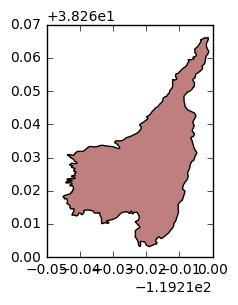

In [49]:
lake = lakes.ix[lakes.COMID == 8914219] 
lake.plot(figsize=(3,3))

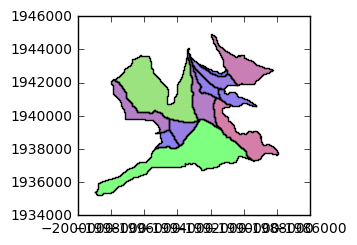

In [47]:
basin.plot(column='AreaSqKM', cmap="brg", figsize=(3,3))

In [55]:
print lake.crs #these need to match for the plot to work below!
print basin.crs

{'init': 'epsg:5070'}
{'init': 'epsg:5070'}


In [53]:
#lake = lake.to_crs({'init': 'epsg:5070'}) # if they are different above, reproject...

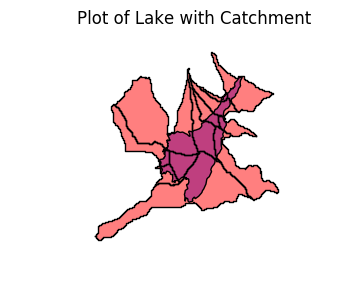

In [54]:
import matplotlib.pyplot as plt
#plt.style.use("default")
fig, ax = plt.subplots(1, figsize=(3,3))
base = lake.plot(ax=ax, color='blue')
basin.plot(ax=base, color='red') #
ax.axis('off')
ax.set_title("Plot of Lake with Catchment")

In [ ]:
lakes.query?

In [16]:
lakes.loc[lakes['COMID'] == 4562850] # all of these methods can be used to lookup records
lakes.ix[lakes.COMID == 4562850]
lakes.ix[lakes.COMID.isin([4562850])]
lakes.query("COMID == 4562850")

,AREASQKM,COMID,ELEVATION,FCODE,FDATE,FTYPE,GNIS_ID,GNIS_NAME,REACHCODE,RESOLUTION,SHAPE_AREA,SHAPE_LENG,VPU,geometry
0,0.079,4562850,0.0,39004,1999-06-22,LakePond,None,None,16010202001481,Medium,0.000009,0.019938,16,"POLYGON ((-111.855203003485 41.90411666828982,..."


In [18]:
basin.crs  # GCS_North_American_1983

{'init': u'epsg:4269'}

In [19]:
print type(basin['geometry'])
print type(basin.ix[1990].geometry) # key in on output from this
print basin.ix[1990].geometry.area
print basin.ix[1990].geometry.length
#convert to new crs for output in meteres
basin_albers = basin.to_crs({'init' :'epsg:5070'})
print basin_albers.ix[1990].geometry.area
print basin_albers.ix[1990].geometry.length

<class 'geopandas.geoseries.GeoSeries'>
<class 'shapely.geometry.polygon.Polygon'>
0.000377074172521
0.146702914954
3660300.0
14220.0


In [21]:
#move to where you cloned the git repo
%cd SDMG 

[Errno 2] No such file or directory: 'SDMG'
/home/rick/SDMG


In [22]:
from StreamCat_functions import findUpstreamNpy

DL_dir = '/home/rick/Downloads/SpatialData'
zone = '16'
lakes = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDWaterbodies.shp' % (DL_dir, zone)).to_crs({'init' :'epsg:5070'})
cats = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDCatchment.shp' % (DL_dir, zone)).to_crs({'init' :'epsg:5070'}) 
lookup = pd.read_csv('%s/lookupCOMS%s.csv' % (DL_dir, zone))

lks = gpd.GeoDataFrame()
bsn = gpd.GeoDataFrame()
miss = gpd.GeoDataFrame()

for idx, row in lookup.iterrows():
    lake = lakes.ix[lakes.COMID == row.wbCOMID]
    catbas = findUpstreamNpy(zone, int(row.catCOMID), DL_dir)
    basin = cats.ix[cats.FEATUREID.isin(catbas)]
    try: 
        diffgeom = lake['geometry'].difference(basin.unary_union.buffer(0))
        pct = diffgeom.area / lake.area * 100
        if pct.values[0] > 20:
            lks = pd.concat([lks, lake])
            bsn = pd.concat([bsn, basin])
            miss = pd.concat([miss, gpd.GeoDataFrame(data={'COMID': row.wbCOMID,'PCT': pct}, geometry=diffgeom)])
    except:
        print row.wbCOMID
        continue
lks.to_crs({'init' :'epsg:4326'}).to_file("%s/lks.json" % DL_dir, driver="GeoJSON")
bsn.to_crs({'init' :'epsg:4326'}).to_file("%s/bsn.json" % DL_dir, driver="GeoJSON")
miss.to_crs({'init' :'epsg:4326'}).to_file("%s/miss.json" % DL_dir, driver="GeoJSON")
miss = miss.to_crs({'init' :'epsg:4326'})

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -1416315.0000000002 1964474.9999999953 at -1416315.0000000002 1964474.9999999953


1197972.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -1254134.9999999998 2232524.9999999977 at -1254134.9999999998 2232524.9999999977


4472015.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -1327755 2037974.9999999946 at -1327755 2037974.9999999946


10327875.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -1348664.9999999988 2118494.9999999995 at -1348664.9999999988 2118494.9999999995


946020001.0


In [23]:
type(lakes.to_crs({'init' :'epsg:4326'}).unary_union.buffer(0).centroid)

shapely.geometry.point.Point

In [24]:
center_point = lakes.to_crs({'init' :'epsg:4326'}).unary_union.buffer(0).centroid
print center_point.x
print center_point.y

-113.901194569
40.7966015367


In [25]:
miss.unary_union.bounds

(-120.14396612395257, 37.48230827515336, -111.1690988712167, 42.20684106781983)

In [26]:
extent = miss.unary_union.bounds
lat_Center = (extent[1] + extent[3]) / 2
lon_Center = (extent[0] + extent[2]) / 2

In [27]:
miss.columns # use COMID in popup / and PCT for color and icon format

Index([u'COMID', u'PCT', u'geometry'], dtype='object')

In [28]:
def color(pct):
    if pct <= 50:
        col=('green','ok')
    elif 50 < pct <= 75:
        col=('blue','remove')
    elif pct > 75:
        col=('darkred','ban-circle')
    return col  

In [29]:
import folium

In [ ]:
folium.Icon?

In [30]:
folium.Map?

In [31]:
f_map=folium.Map(location=[lat_Center , lon_Center],zoom_start=6,tiles="Stamen Terrain", control_scale=True)
fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name,pct in zip(miss['geometry'].centroid.map(lambda p: p.y),miss['geometry'].centroid.map(lambda p: p.x),miss['COMID'],miss['PCT']):    
    fg.add_child(folium.Marker(location=[lat,lon],popup="NHD Waterbody COMID: %s" % int(name),
                                   icon=folium.Icon(icon_color='white', color=color(pct)[0], icon=color(pct)[1])))
f_map.add_child(fg)
f_map.add_child(folium.GeoJson(data=open('%s/lks.json' % DL_dir),
                name='NHD Lake',
                style_function=lambda x: {'fillColor':'blue', 
                                          'fill_opacity': 0.2, 
                                          'color':'none'}))
f_map.add_child(folium.GeoJson(data=open('%s/bsn.json' % DL_dir),
                name='Catchment Basin',
                style_function=lambda x: {'fillColor':'grey', 
                                          'fill_opacity': 0.74,
                                          'color':'white'}))
f_map.add_child(folium.GeoJson(data=open('%s/miss.json' % DL_dir),
                name='Missed Area',
                style_function=lambda x: {'fillColor':'red', 
                                          'fill_opacity': 0.2, 
                                          'color':'none'}))
f_map.add_child(folium.LayerControl())

In [32]:
f_map.save(outfile='%s/f_map.html' % DL_dir)

## Links to icons to use with markers
* [FontAwesome](http://fontawesome.io/icons/)
* [GlyphIcons](http://glyphicons.bootstrapcheatsheets.com/)

## Here is the map of all lakes with > 50% coverage
* # [All Over 50](http://debboutr.github.io/tot_1.html)

## [Notebook](https://anaconda.org/debboutr/lightning/notebook) of bokeh package
* # [Calapooia](http://debboutr.github.io/Calapooia_PolyCats.html)
* # [DC Road Density](http://debboutr.github.io/DC_Plot_rdDens.html)

In [ ]:
type(lakes.ix[0].geometry)

In [ ]:
?pd.qcut

In [ ]:
list(lakes.ix[0].geometry.exterior.coords)

### Useful python commands when navigating environments

In [1]:
import sys
print sys.prefix
print sys.executable
import os
print os.getcwd()

/home/rick/anaconda2/envs/envName
/home/rick/anaconda2/envs/envName/bin/python
/home/rick/SDMG
